# Data Loading

Before we can perform any model training, we need to load our data into a format that PyTorch can interact with.

## PyTorch Data Utilities

PyTorch provides two utilities for separating data handling code from model training code, `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`, for storing and interacting with data respectively.

### `torch.utils.data.Dataset`

`torch.utils.data.Dataset` is an abstract class representing a dataset. Datasets in PyTorch are subclasses (children) of this base class (parent). PyTorch provides both built-in datasets and the ability to add your own datasets by instantiating subclasses of `torch.utils.data.Dataset`.

You can learn more about `torch.utils.data.Dataset` [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset). 

### `torch.utils.data.DataLoader`

`torch.utils.data.DataLoader` provides the ability to iterate over a dataset, and perform common operations on that data with support for multi-processing if desired. Operations supported include shuffling data, sampling data, loading data in batches, employing subprocesses to load the data, and more.

**Any class which is a subclass of `torch.utils.data.Dataset` can be passed to `torch.utils.DataLoader`.** This is incredibly convenient since any built-in dataset, and any data we add that is a subclass of `torch.utils.data.Dataset` is eligible to be interacted with through the convenience of `torch.utils.data.DataLoader`.

You can learn more about `torch.utils.data.DataLoader` [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

### Built-in Datasets

PyTorch includes many built-in subclasses of `torch.utils.data.Dataset`, all ready to be used and interacted with via `torch.utils.data.DataLoader`. Check out [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) as an example.

These include [vision datasets](https://pytorch.org/vision/stable/datasets.html), [text datasets](https://pytorch.org/text/stable/datasets.html), and [audio datasets](https://pytorch.org/audio/stable/datasets.html).

We will see examples of using built-in datasets and loading our own data below.

## Imports

Here we import the `torch` dependencies and other basic dependencies we'll need.

In [1]:
import torch

# Model building
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Data loading
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

# Visualization
import matplotlib.pyplot as plt

# Seed and device configuration
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Setup

We will need a model to train for these examples. Here we setup a simple model using the same paradigms we have been studying so far.

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        y = F.log_softmax(x, dim=1)
        return y

## Examples

Here we look at some examples of using PyTorch's builtin datasets and loading our own.

### Loading MNIST

Here we load MNIST.

Downloading the dataset might require dependencies. In this case, `gdown` is required and already installed in this environment. If it is not, you can install it with `pip install gdown` or `poetry add gdown` if using Poetry.

Different datasets support different arguments which control how they are loaded. Most datasets allow you to at minimum:

* specify a folder where the data is to be stored with `root`,
* Pass a transform you would like to apply to each example via the `transform` parameter,
* Specify that you want to download the dataset if it is *not* available at root via the `download` parameter.

We use transforms from `torchvision` to resize our images to a common size and transform them to PyTorch tensors.


In [3]:
dataset = datasets.MNIST(
    root="example_data", download=True, transform=transforms.ToTensor()
)

### Exploring MNIST

Let's learn about the data we just downloaded. We see that this is an object of class `torchvision.datasets.mnist.MNIST` which inherits from `torchvision.datasets.vision.VisionDataset`. Printing the dataset reveals some basic information.

In [4]:
print(type(dataset))
print(type(dataset).__base__)
print(dataset)

<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.vision.VisionDataset'>
Dataset MNIST
    Number of datapoints: 60000
    Root location: example_data
    Split: Train
    StandardTransform
Transform: ToTensor()


We can see all the useful information packaged into this dataset by using Python's `dir` to get all the class's attributes and using list comprehension to remove any that have the `_` which indicates they are meant to be private.

In [5]:
def print_attributes(my_object):
    print(
        "\n".join(
            [
                attribute
                for attribute in dir(my_object)
                if not attribute.startswith("_")
            ]
        )
    )


print_attributes(dataset)

class_to_idx
classes
data
download
extra_repr
mirrors
processed_folder
raw_folder
resources
root
target_transform
targets
test_data
test_file
test_labels
train
train_data
train_labels
training_file
transform
transforms


We can inspect some of these attributes to get a feel for what the dataset enables us to do.

In [6]:
print("Annotation categories:", dataset.class_to_idx)
print("Categories:", dataset.classes)
print("Root directory of data:", dataset.root)
print("Transforms applied to data:", dataset.transforms)
print("Numerical labels:", dataset.targets)

Annotation categories: {'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}
Categories: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Root directory of data: example_data
Transforms applied to data: StandardTransform
Transform: ToTensor()
Numerical labels: tensor([5, 0, 4,  ..., 5, 6, 8])


We can also see that indexing the data returns a tuple **at each index**. The first entry is the image and the second is the label.

In [7]:
sample_index = 0
print(type(dataset[sample_index]))
print(len(dataset[sample_index]))

# Image
print(dataset[sample_index][0])
print(dataset[sample_index][0].shape)

# Label
print(dataset[sample_index][1])

<class 'tuple'>
2
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.000

We can visualize the contents of the dataset like we would any other data.

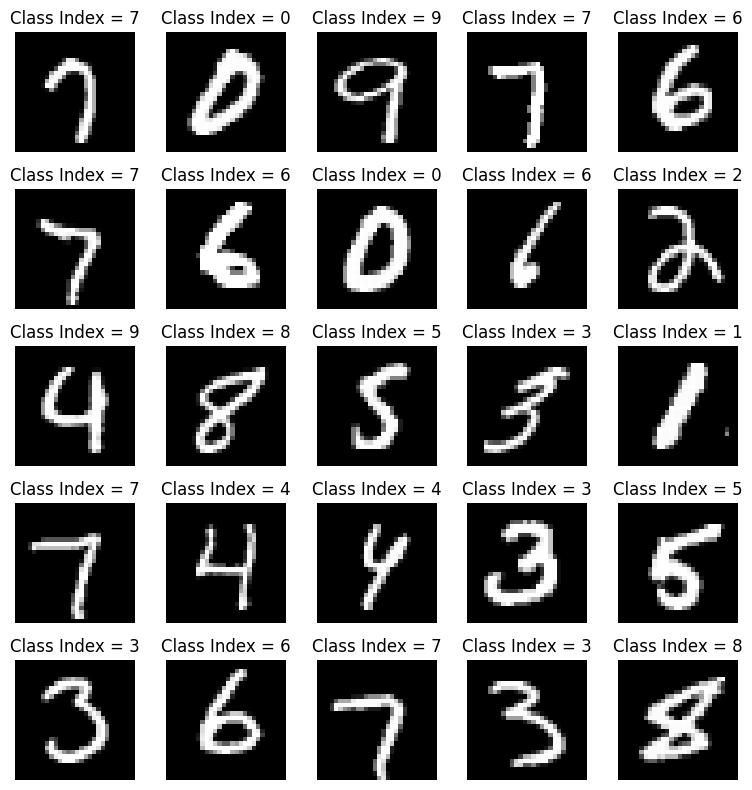

In [8]:
figure = plt.figure(figsize=(8, 8))
columns, rows = 5, 5
for index in range(1, columns * rows + 1):
    sample_index = torch.randint(len(dataset), size=(1,)).item()
    image, label = dataset[sample_index]
    figure.add_subplot(rows, columns, index)
    plt.axis("off")
    plt.imshow(image.permute(1, 2, 0).squeeze(), cmap="gray")
    plt.title("Class Index = {}".format(label))
    plt.tight_layout()
plt.show()

### Fitting a Model

To begin fitting a model, we start with a train-test split.

In [9]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
print(train_loader)
print(type(train_loader))
print(type(train_loader).__base__)
print_attributes(train_loader)

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'typing.Generic'>
batch_sampler
batch_size
check_worker_number_rationality
collate_fn
dataset
drop_last
generator
multiprocessing_context
num_workers
persistent_workers
pin_memory
pin_memory_device
prefetch_factor
sampler
timeout
worker_init_fn


In [12]:
from dataclasses import dataclass


@dataclass
class TrainingParameters:
    """Training parameters for a simple neural network trainer."""

    batch_size: int = 64
    test_batch_size: int = 1000
    epochs: int = 3
    lr: float = 1.0
    gamma: float = 0.7
    dry_run: bool = False
    seed: int = 1
    save_model: bool = True


def predict(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction="sum").item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )


def run_training_epoch(
    training_params, model, device, train_loader, optimizer, epoch
):
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if training_params.dry_run:
            break
        if batch_index % round(len(train_loader) / 80) == 0:
            print(".", end="")
    print("")
    print("Train Epoch: {} \tLoss: {:.6f}".format(epoch, loss.item()))

    if training_params.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


def train(model, training_params, device, train_loader, test_loader):
    optimizer = optim.Adadelta(model.parameters(), lr=training_params.lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=training_params.gamma)

    for epoch in range(1, training_params.epochs + 1):
        run_training_epoch(
            training_params, model, device, train_loader, optimizer, epoch
        )
        predict(model, device, test_loader)
        scheduler.step()

In [13]:
model = SimpleCNN().to(device)
training_params = TrainingParameters(epochs=3, dry_run=False)
train(model, training_params, device, train_loader, test_loader)

....................................................................................
Train Epoch: 1 	Loss: 0.028587

Test set: Average loss: 0.0685, Accuracy: 11760/12000 (98%)

....................................................................................
Train Epoch: 2 	Loss: 0.013154

Test set: Average loss: 0.0556, Accuracy: 11818/12000 (98%)

....................................................................................
Train Epoch: 3 	Loss: 0.015043

Test set: Average loss: 0.0481, Accuracy: 11832/12000 (99%)

